In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [2]:
drds=0.8
drdt=-1

In [3]:
Tl = np.zeros( (3,2) )
Tr = np.zeros( (3,2) )
zl = np.zeros( (3,2) )
zr = np.zeros( (3,2) )

In [4]:
Tl[0,:] = [22,18]
Tl[1,:] = [18,14]
Tl[2,:] = [14,10]
Tr[0,:] = [22,18]
Tr[1,:] = [18,14]
Tr[2,:] = [14,10]

Tl[0,:] = [22,18]
Tl[1,:] = [18,14]
Tl[2,:] = [14,10]
Tr[0,:] = [20,16]
Tr[1,:] = [16,12]
Tr[2,:] = [12,8]

nk = 3
hl = np.ones( nk )*10
hr = np.ones( nk )*10
ns = 3*4

zl[0,0] = 0
zr[0,0] = 0
zl[0,1] = hl[0]
zr[0,1] = hr[0]

for k in range(1,nk):
  zl[k,0] = zl[k-1,1]
  zl[k,1] = zl[k,0] + hl[k]
  zr[k,0] = zr[k-1,1]
  zr[k,1] = zr[k,0] + hr[k]
  
point_left = np.zeros(ns)

In [5]:
def calc_drho( T1, drdt1, T2, drdt2 ):
  if T1 == T2:
    return 0
  else:
    return 0.5*(drdt1 + drdt2)*( T1 - T2 )
def find_pos(drhoneg, drhopos):
  if drhopos - drhoneg > 0:
    pos = -drhoneg/(drhopos-drhoneg)
  elif drhopos-drhoneg  == 0.:
    if drhoneg > 0.:
      pos = 0.
    else:
      pos = 1.
  if (pos < 0) or (pos > 1):
    print("SOMETHING WENT WRONG",pos)
  return pos
def abs_pos(zl,kl,pos):
  kl = np.int(kl)
  return zl[kl,0]*(1-pos) + zl[kl,1]*pos
  

In [159]:
def sorting_algorithm(Tl, Tr, zl, zr, drdt, verbose = False):
    drdp = 1.e-5
    ki_left = 0 ; ki_right = 0
    kl_left = 0 ; kl_right = 0
    reached_bottom = False
    searching_left_column  = True
    searching_right_column = True
    PoL = np.zeros( ns )
    PoR = np.zeros( ns )
    KoL = np.zeros( ns )
    KoR = np.zeros( ns )

    # For the first surface we just need to figure out which top interface is lighter
    drho = calc_drho(Tl[0,0], drdt, Tr[0,0], drdt)

    for ksurf in range(0,ns):
      if verbose: 
          print("ksurf: %d kl_left: %d ki_left: %d kl_right: %d ki_right: %d" %
               (ksurf, kl_left, ki_left, kl_right, ki_right))
      # Need to check the interfaces of each side to see which direction we should search
      drho = calc_drho(Tr[kl_right,ki_right], drdt, Tl[kl_left,ki_left], drdt)
      if verbose:
          print("drho: %f Tl[%d,%d]: %f, Tr[%d,%d]: %f" % (drho, kl_left,ki_left,Tl[kl_left,ki_left],
                                                       kl_right,ki_right,Tr[kl_right,ki_right]))

      if not reached_bottom:
        if drho < 0:
          if verbose:
              print("drho < 0: Search left")
          searching_left_column  = True
          searching_right_column = False
        elif drho > 0:
          if verbose:
              print("drho > 0: Search right")
          searching_left_column  = False
          searching_right_column = True
        else:
          if (kl_left == 0) and (kl_right == 0) and ((ki_left + ki_right) == 0):
            if verbose:
                print("drho = 0: At surface")
            searching_left_column  = True
            searching_right_column = False
          else:
            if verbose:
                print("drho = 0: Switch direction")
            searching_left_column  = not searching_left_column
            searching_right_column = not searching_right_column

      if searching_left_column:
        # The position of the interface we're searching from is now known
        PoR[ksurf] = ki_right
        KoR[ksurf] = kl_right

        # Figure out whether the layer is stable relative to the interface
        T_ref = Tr[kl_right,ki_right]
        drhotop = calc_drho(Tl[kl_left,0], drdt, T_ref, drdt)
        drhobot = calc_drho(Tl[kl_left,1], drdt, T_ref, drdt)
        
        # If a layer is perfectly unstratified, then a surface could connect to either
        # the top or the bottom. To get a unique solution add a little bit of pressure
        # dependence
        if drhotop == drhobot:
            drhotop = drhotop + zl[kl_left,0]*drdp
            drhobot = drhobot + zl[kl_left,1]*drdp

        # Set the position on the left column
        if drhotop > 0. or ksurf == 0:
          PoL[ksurf] = 0.
        if drhotop == 0. and drhotop < drhobot:
          PoL[ksurf] = 0.
        elif drhotop >= drhobot:
          PoL[ksurf] = 1.
        elif drhotop < 0. and drhobot < 0.:
          PoL[ksurf] = 1.
        else:
          PoL[ksurf] = find_pos(drhotop,drhobot)
        KoL[ksurf] = kl_left

        # Check if we've reached the bottom, otherwise increment the interface/layer
        if (ki_right == 1):
            if (kl_right < nk-1):
                kl_right = kl_right + 1
                ki_right = 0
            else:
              reached_bottom = True
              searching_right_column = True
              searching_left_column  = False
        else:
            ki_right = 1
        point_left[ksurf] = True
        if verbose:
            print("\tSearch left")
            print("\t\t Temp right: %f" % T_ref)
            print("\t\t Temp left top: %f" % Tl[kl_left,0])
            print("\t\t Temp left bot: %f" % Tl[kl_left,1])
            print("\t\t drhotop: %f drhobot: %f" % (drhotop, drhobot))
            print("\t\t PoL: %f" % PoL[ksurf])

      elif searching_right_column:
        # The position of the interface we're searching from is now known
        PoL[ksurf] = ki_left
        KoL[ksurf] = kl_left

        # Figure out whether the layer is stable relative to the interface
        T_ref = Tl[kl_left,ki_left]
        drhotop = calc_drho(Tr[kl_right,0], drdt, T_ref, drdt)
        drhobot = calc_drho(Tr[kl_right,1], drdt, T_ref, drdt)
        
        # If a layer is perfectly unstratified, then a surface could connect to either
        # the top or the bottom. To get a unique solution add a little bit of pressure
        # dependence
        if drhotop == drhobot:
            drhotop = drhotop + zr[kl_right,0]*drdp
            drhobot = drhobot + zr[kl_right,1]*drdp
            
        # Set the position on the left column
        if drhotop > 0. or ksurf == 0:
          PoR[ksurf] = 0.
        if drhotop == 0. and drhotop < drhobot:
            PoR[ksurf] = 0
        elif drhotop >= drhobot:
          PoR[ksurf] = 1.
        elif drhotop < 0. and drhobot < 0.:
          PoR[ksurf] = 1.
        else:
          PoR[ksurf] = find_pos(drhotop,drhobot)
        KoR[ksurf] = kl_right

        # Check if we've reached the bottom, otherwise increment the interface/layer
        if (ki_left == 1):
            if (kl_left < nk-1):
                kl_left = kl_left + 1
            else:
              reached_bottom = True
              searching_right_column = False
              searching_left_column  = True
        else:
            ki_left = 1
        point_left[ksurf] = False
        if verbose:
            print("\tSearch right")
            print("\t\t Temp left: %f" % T_ref)
            print("\t\t Temp right top: %f" % Tr[kl_right,0])
            print("\t\t Temp right bot: %f" % Tr[kl_right,1])
            print("\t\t drhotop: %f drhobot: %f" % (drhotop, drhobot))
            print("\t\t PoR: %f" % PoR[ksurf])
      else:
        print("WAAAAAAAAA")
    return KoL, PoL, KoR, PoR, point_left

In [160]:
def plot_surfaces(KoL, PoL, KoR, PoR, point_left, zl, zr):
    plt.figure()
    for ks in range(0,ns):
      if point_left[ks] == 1.:
        x0 = 1
        y0 = abs_pos( zr, KoR[ks], PoR[ks] )
        x1 = 0
        y1 = abs_pos( zl, KoL[ks], PoL[ks] )
      else:
        x0 = 0
        y0 = abs_pos( zl, KoL[ks], PoL[ks] )
        x1 = 1
        y1 = abs_pos( zr, KoR[ks], PoR[ks] )
      plt.text(x0,y0,ks)
      plt.plot([x0,x1],[y0,y1],'k')
    plt.xlim((-0.5, 1.5))
    plt.ylim((-5, 35))
    plt.gca().invert_yaxis()

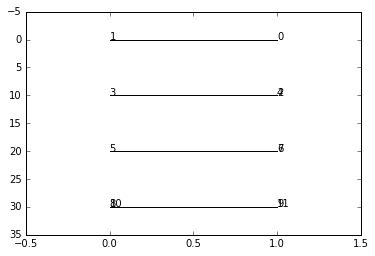

In [161]:
Tl[0,:] = [22,18]
Tl[1,:] = [18,14]
Tl[2,:] = [14,10]
Tr[0,:] = [22,18]
Tr[1,:] = [18,14]
Tr[2,:] = [14,10]
KoL, PoL, KoR, PoR, point_left = sorting_algorithm(Tl,Tr,zl,zr,drdt)
plot_surfaces( KoL, PoL, KoR, PoR, point_left, zl, zr )

SOMETHING WENT WRONG -0.5
    KoL  KoR  PoL  PoR
0   0.0  0.0  0.0 -0.5
1   0.0  0.0  0.5  0.0
2   0.0  0.0  1.0  0.5
3   1.0  0.0  0.5  1.0
4   1.0  1.0  0.5  0.0
5   1.0  1.0  1.0  0.5
6   2.0  1.0  0.5  1.0
7   2.0  2.0  0.5  0.0
8   2.0  2.0  1.0  0.5
9   2.0  2.0  1.0  1.0
10  2.0  2.0  1.0  0.5
11  2.0  2.0  1.0  1.0


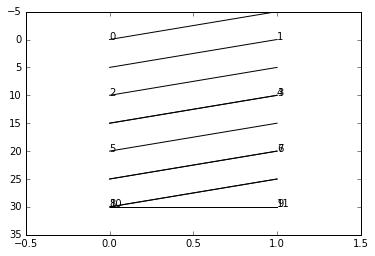

In [162]:
Tl[0,:] = [22,18]
Tl[1,:] = [18,14]
Tl[2,:] = [14,10]
Tr[0,:] = [20,16]
Tr[1,:] = [16,12]
Tr[2,:] = [12,8]

KoL, PoL, KoR, PoR, point_left = sorting_algorithm(Tl,Tr,zl,zr,drdt)
plot_surfaces( KoL, PoL, KoR, PoR, point_left, zl, zr )
print(pd.DataFrame( {'KoL':KoL, 'KoR':KoR, 'PoL':PoL, 'PoR':PoR} ))


ksurf: 0 kl_left: 0 ki_left: 0 kl_right: 0 ki_right: 0
drho: 8.000000 Tl[0,0]: 22.000000, Tr[0,0]: 14.000000
drho > 0: Search right
SOMETHING WENT WRONG -80000.0000002
	Search right
		 Temp left: 22.000000
		 Temp right top: 14.000000
		 Temp right bot: 14.000000
		 drhotop: 8.000000 drhobot: 8.000100
		 PoR: -80000.000000
ksurf: 1 kl_left: 0 ki_left: 1 kl_right: 0 ki_right: 0
drho: 4.000000 Tl[0,1]: 18.000000, Tr[0,0]: 14.000000
drho > 0: Search right
SOMETHING WENT WRONG -40000.0000001
	Search right
		 Temp left: 18.000000
		 Temp right top: 14.000000
		 Temp right bot: 14.000000
		 drhotop: 4.000000 drhobot: 4.000100
		 PoR: -40000.000000
ksurf: 2 kl_left: 1 ki_left: 1 kl_right: 0 ki_right: 0
drho: 0.000000 Tl[1,1]: 14.000000, Tr[0,0]: 14.000000
drho = 0: Switch direction
	Search left
		 Temp right: 14.000000
		 Temp left top: 18.000000
		 Temp left bot: 14.000000
		 drhotop: -4.000000 drhobot: 0.000000
		 PoL: 1.000000
ksurf: 3 kl_left: 1 ki_left: 1 kl_right: 0 ki_right: 1
drho: 0.

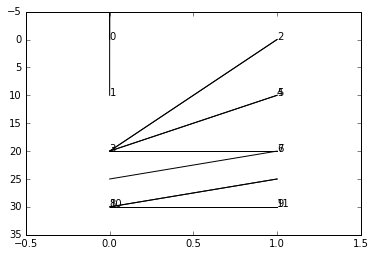

In [164]:
Tl[0,:] = [22,18]
Tl[1,:] = [18,14]
Tl[2,:] = [14,10]
Tr[0,:] = [14,14]
Tr[1,:] = [14,14]
Tr[2,:] = [12,8]

KoL, PoL, KoR, PoR, point_left = sorting_algorithm(Tl,Tr,zl,zr,drdt,verbose=True)
plot_surfaces( KoL, PoL, KoR, PoR, point_left, zl, zr )
print(pd.DataFrame( {'KoL':KoL, 'KoR':KoR, 'PoL':PoL, 'PoR':PoR} ))


ksurf: 0 kl_left: 0 ki_left: 0 kl_right: 0 ki_right: 0
drho: 0.000000 Tl[0,0]: 14.000000, Tr[0,0]: 14.000000
drho = 0: At surface
	Search left
		 Temp right: 14.000000
		 Temp left top: 14.000000
		 Temp left bot: 14.000000
		 drhotop: 0.000000 drhobot: 0.100000
		 PoL: 0.000000
ksurf: 1 kl_left: 0 ki_left: 0 kl_right: 0 ki_right: 1
drho: 0.000000 Tl[0,0]: 14.000000, Tr[0,1]: 14.000000
drho = 0: Switch direction
	Search right
		 Temp left: 14.000000
		 Temp right top: 14.000000
		 Temp right bot: 14.000000
		 drhotop: 0.000000 drhobot: 0.100000
		 PoR: 0.000000
ksurf: 2 kl_left: 0 ki_left: 1 kl_right: 0 ki_right: 1
drho: 0.000000 Tl[0,1]: 14.000000, Tr[0,1]: 14.000000
drho = 0: Switch direction
	Search left
		 Temp right: 14.000000
		 Temp left top: 14.000000
		 Temp left bot: 14.000000
		 drhotop: 0.000000 drhobot: 0.100000
		 PoL: 0.000000
ksurf: 3 kl_left: 0 ki_left: 1 kl_right: 1 ki_right: 0
drho: 4.000000 Tl[0,1]: 14.000000, Tr[1,0]: 10.000000
drho > 0: Search right
SOMETHING WENT

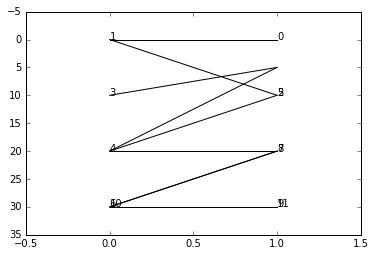

In [153]:
Tl[0,:] = [14,14]
Tl[1,:] = [14,14]
Tl[2,:] = [10,2]
Tr[0,:] = [14,14]
Tr[1,:] = [10,2]
Tr[2,:] = [10,2]

KoL, PoL, KoR, PoR, point_left = sorting_algorithm(Tl,Tr,zl,zr,drdt,verbose=True)
plot_surfaces( KoL, PoL, KoR, PoR, point_left, zl, zr )
print(pd.DataFrame( {'KoL':KoL, 'KoR':KoR, 'PoL':PoL, 'PoR':PoR} ))
